# Encoder-Decoder Model with Attention: 2 Layer LSTM & Scratch Embedding
# (Word Level)

## Loading Libraries

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import pandas as pd
import re
import datetime
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import nltk.translate.bleu_score as bleu
import tensorflow as tf
from tensorflow.keras.layers import Input, Softmax, RNN, Dense, Embedding, LSTM, Flatten, Activation 
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import TensorBoard
import matplotlib.ticker as ticker
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading Dataset

In [ ]:
data_path = '/content/drive/MyDrive/CS2/2.Datasets/'
model_path = '/content/drive/MyDrive/CS2/3.Models/4_4_Attention2-Word-Scratch/'

In [ ]:
data = pd.read_csv(data_path + 'final_data.csv')
print(data.shape)
data.head()

(101717, 2)


,input_text,output_text
0,"Ofcouse , I love cheap fashion , fast fashion ...","Of course , I love cheap , fast fashion like f..."
1,If he want to listen to music that I do n't li...,If he wants to listen to music that I do n't l...
2,This happened because of the cultural differen...,This happened because of the cultural differen...
3,I 'm gon na earn much money to study abroad .,I 'm gon na earn enough money to study abroad .
4,It is not difficult for me but answer phones a...,It is not difficult for me but answering the p...


## Preprocess Data

In [ ]:
def clean(text):
    text = re.sub('<.*>', '', text)
    text = re.sub('\(.*\)', '', text)
    text = re.sub('\[.*\]', '', text)
    text = re.sub('{.*}', '', text)
    text = re.sub("[-+@#^/|*(){}$~`<>=_]","",text)
    text = text.replace("\\","")
    text = re.sub("\[","",text)
    text = re.sub("\]","",text)
    text = re.sub("[0-9]","",text)
    return text

data['input_text'] = data['input_text'].apply(lambda x: clean(x))
data['output_text'] = data['output_text'].apply(lambda x: clean(x))

In [ ]:
def preprocessing(data):
   
    data['input_text_length'] = data['input_text'].str.split().apply(len)
    data['output_text_length'] = data['output_text'].str.split().apply(len)

    data = data[data['input_text_length'] < 25]
    data = data[data['output_text_length'] < 25]

    data['output_text_in'] = '<start> ' + data['output_text'].astype(str)
    data['output_text_out'] = data['output_text'].astype(str) + ' <end>'

    data = data.drop(['input_text_length','output_text_length','output_text'], axis=1)
    return data

In [ ]:
data = preprocessing(data)

data.iloc[0]['output_text_in'] = str(data.iloc[0]['output_text_in'])+' <end>'
data.iloc[0]['output_text_out'] = str(data.iloc[0]['output_text_out'])+' <end>'

print('Shape of Dataset:', data.shape)
data.head()

Shape of Dataset: (93503, 3)


,input_text,output_text_in,output_text_out
0,"Ofcouse , I love cheap fashion , fast fashion ...","<start> Of course , I love cheap , fast fashio...","Of course , I love cheap , fast fashion like f..."
1,If he want to listen to music that I do n't li...,<start> If he wants to listen to music that I ...,If he wants to listen to music that I do n't l...
2,This happened because of the cultural differen...,<start> This happened because of the cultural ...,This happened because of the cultural differen...
3,I 'm gon na earn much money to study abroad .,<start> I 'm gon na earn enough money to study...,I 'm gon na earn enough money to study abroad ...
4,It is not difficult for me but answer phones a...,<start> It is not difficult for me but answeri...,It is not difficult for me but answering the p...


## Train Test Split

In [ ]:
train, test = train_test_split(data, test_size=0.1, random_state=42)
print('Shape of Train Data:', train.shape)
print('Shape of Test Data:', test.shape)

Shape of Train Data: (84152, 3)
Shape of Test Data: (9351, 3)


## Tokenization

In [ ]:
tokenizer_i = Tokenizer(filters="", char_level=False, lower=False)
tokenizer_o = Tokenizer(filters="", char_level=False, lower=False)

tokenizer_i.fit_on_texts(train['input_text'].values)
tokenizer_o.fit_on_texts(train['output_text_in'].values)

vocab_size_input = len(tokenizer_i.word_index.keys())
print('Input Vocab Size:', vocab_size_input)

vocab_size_output = len(tokenizer_o.word_index.keys())
print('Output Vocab Size:', vocab_size_output)

Input Vocab Size: 35510
Output Vocab Size: 29350


## Data Pipeline

In [ ]:
class Dataset:
    def __init__(self, data, tokenizer_i, tokenizer_o, max_len_enc, max_len_dec):
        self.encoder_inps = data['input_text'].values
        self.decoder_inps = data['output_text_in'].values
        self.decoder_outs = data['output_text_out'].values
        self.tokenizer_o = tokenizer_o
        self.tokenizer_i = tokenizer_i
        self.max_len_enc = max_len_enc
        self.max_len_dec = max_len_dec


    def __getitem__(self, i):
        self.encoder_seq = self.tokenizer_i.texts_to_sequences([self.encoder_inps[i]]) 
        self.decoder_inp_seq = self.tokenizer_o.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tokenizer_o.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len_enc, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len_dec, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len_dec, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self):
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self): 
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [ ]:
train_dataset = Dataset(train, tokenizer_i, tokenizer_o, 25, 25)
test_dataset  = Dataset(test, tokenizer_i, tokenizer_o, 25, 25)

train_dataloader = Dataloder(train_dataset, batch_size=512)
test_dataloader = Dataloder(test_dataset, batch_size=512)

print('Train Dataloader:', train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)
print('Test Dataloader:', test_dataloader[0][0][0].shape, test_dataloader[0][0][1].shape, test_dataloader[0][1].shape)

Train Dataloader: (512, 25) (512, 25) (512, 25)
Test Dataloader: (512, 25) (512, 25) (512, 25)


## Model Building

In [ ]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns encoder-outputs,encoder_final_state_h,encoder_final_state_c
    '''
    def __init__(self,in_vocab_size,embedding_dim,enc_units,input_length):
        super().__init__()
        self.in_vocab_size = in_vocab_size
        self.embedding_dim = embedding_dim
        self.input_length = input_length
        self.enc_units = enc_units

    def build(self, input_shape):
        self.embedding = Embedding(input_dim=self.in_vocab_size, output_dim=self.embedding_dim, input_length=self.input_length, mask_zero=True, name="Encoder_Embedding")
        self.lstm_1 = LSTM(self.enc_units, return_state=True, return_sequences=True, name="Encoder_LSTM_1")
        self.lstm_2 = LSTM(self.enc_units, return_state=True, return_sequences=True, name="Encoder_LSTM_2")

        
    def call(self, input_sentences, training=True):
        input_embed = self.embedding(input_sentences)
        encoder_output, encoder_state_h, encoder_state_c = self.lstm_1(input_embed)
        encoder_output, encoder_state_h, encoder_state_c = self.lstm_2(encoder_output)

        return encoder_output, encoder_state_h, encoder_state_c

#-----------------------------------------------------------------------------------------------------------------------------------
class Attention(tf.keras.layers.Layer):
  '''
  Class the calculates score based on the scoring_function using Bahdanu attention mechanism.
  '''
  def __init__(self,scoring_function, att_units):
    super().__init__()
    self.scoring_function = scoring_function
    self.att_units = att_units

    if self.scoring_function == 'dot':
      pass

    if scoring_function == 'general':
      self.W = Dense(self.att_units)
      
    elif scoring_function == 'concat':
      self.W1 = Dense(self.att_units)
      self.W2 = Dense(self.att_units)
      self.Va = Dense(1)
  
  
  def call(self,decoder_hidden_state,encoder_output):
    if self.scoring_function == 'dot':
        decoder_hidden_state = tf.expand_dims(decoder_hidden_state, 2)
        score = tf.matmul(encoder_output, decoder_hidden_state)

    elif self.scoring_function == 'general':
        decoder_hidden_state = tf.expand_dims(decoder_hidden_state, 2)
        score = tf.matmul(self.W(encoder_output), decoder_hidden_state)

    elif self.scoring_function == 'concat':
        decoder_hidden_state = tf.expand_dims(decoder_hidden_state, 1)
        score = self.Va(tf.nn.tanh(self.W1(decoder_hidden_state) + self.W2(encoder_output)))

    attention_weight = tf.nn.softmax(score, axis=1)
    context_vector = tf.reduce_sum(attention_weight * encoder_output, axis=1)
    return context_vector, attention_weight

#-----------------------------------------------------------------------------------------------------------------------------------
class One_Step_Decoder(tf.keras.Model):
  def __init__(self, tar_vocab_size, embedding_dim, input_length, dec_units, score_fun, att_units):
      super().__init__()
      self.tar_vocab_size = tar_vocab_size
      self.embedding_dim = embedding_dim
      self.input_length = input_length
      self.dec_units= dec_units
      self.score_fun = score_fun
      self.att_units = att_units

  def build(self, input_shape):
        self.embedding = Embedding(input_dim=self.tar_vocab_size, output_dim=self.embedding_dim, input_length=self.input_length, mask_zero=True, name="Decoder_Embedding")
        self.lstm = LSTM(self.dec_units, return_state=True, return_sequences=True, name="Decoder_LSTM")
        self.dense = Dense(self.tar_vocab_size)
        self.attention = Attention(self.score_fun, self.att_units)

  def call(self,input_to_decoder, encoder_output, state_h, state_c):
    
    target_embedd = self.embedding(input_to_decoder)

    context_vector, attention_weights = self.attention(state_h, encoder_output)
    context_vector = tf.expand_dims(context_vector, 1)

    decoder_input = tf.concat([target_embedd, context_vector], 2)

    decoder_output, decoder_final_state_h, decoder_final_state_c = self.lstm(decoder_input, initial_state=[state_h,state_c])

    output = self.dense(decoder_output)

    return tf.squeeze(output), decoder_final_state_h, decoder_final_state_c, attention_weights, tf.squeeze(context_vector)

#-----------------------------------------------------------------------------------------------------------------------------------
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size, embedding_dim, input_length, dec_units ,score_fun, att_units):
      super(Decoder, self).__init__()
      self.out_vocab_size = out_vocab_size
      self.embedding_dim = embedding_dim
      self.input_length = input_length
      self.dec_units = dec_units
      self.score_fun = score_fun
      self.att_units = att_units
      self.one_step_decoder = One_Step_Decoder(self.out_vocab_size, self.embedding_dim, self.input_length, self.dec_units, self.score_fun, self.att_units)

   
    def call(self, input_to_decoder, encoder_output_state, decoder_hidden_state, decoder_cell_state):
      all_outputs = tf.TensorArray(tf.float32, size=tf.shape(input_to_decoder)[1], name="output_arrays")

      for timestep in range(tf.shape(input_to_decoder)[1]):
        output, decoder_hidden_state, decoder_cell_state, attention_weights, context_vector = self.one_step_decoder(input_to_decoder[:,timestep:timestep+1], encoder_output_state, decoder_hidden_state, decoder_cell_state)
        all_outputs = all_outputs.write(timestep, output)

      all_outputs = tf.transpose(all_outputs.stack(), [1, 0, 2])
      return all_outputs

#-----------------------------------------------------------------------------------------------------------------------------------
class Encoder_Decoder(tf.keras.Model):
  def __init__(self, encoder_inputs_length, decoder_inputs_length, input_vocab_size, output_vocab_size, embedding_dim, enc_units, dec_units, att_units, batch_size, score_fun, name='Encoder-Decoder-Attention'):
    super().__init__(name=name)
    self.encoder = Encoder(in_vocab_size=input_vocab_size+1, embedding_dim=embedding_dim, enc_units=enc_units, input_length=encoder_inputs_length)
    self.decoder = Decoder(out_vocab_size=output_vocab_size+1, embedding_dim=embedding_dim, input_length=decoder_inputs_length, dec_units=dec_units, score_fun=score_fun, att_units=att_units)
    self.batch_size = batch_size

  def call(self,data):

    input, output = data[0], data[1]

    encoder_output, encoder_h, encoder_c = self.encoder(input)
    decoder_output = self.decoder(output, encoder_output, encoder_h, encoder_c)
    return decoder_output

## Custom Loss Function

In [ ]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

## Model Training

In [ ]:
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.99, patience=100)
es = tf.keras.callbacks.EarlyStopping(patience=3, verbose=1, min_delta=0.001, monitor='val_loss', mode='min', restore_best_weights=True)

train_steps = train.shape[0]//512
valid_steps = test.shape[0]//512

model  = Encoder_Decoder(encoder_inputs_length=25,
                          decoder_inputs_length=25,
                          input_vocab_size=vocab_size_input,
                          output_vocab_size=vocab_size_output, 
                          embedding_dim=300, 
                          enc_units=256, 
                          dec_units=256, 
                          att_units=256,
                          batch_size=512,
                          score_fun='dot')

model.compile(optimizer=tf.keras.optimizers.Adam(),loss=loss_function)

20 Epoch

In [ ]:
with tf.device('/device:GPU:0'):
    history20 = model.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=20, validation_data=train_dataloader, validation_steps=train_steps, callbacks=[lr,es])

Epoch 1/20
164/164 [==============================] - 293s 2s/step - loss: 3.2583 - val_loss: 2.9571
Epoch 2/20
164/164 [==============================] - 278s 2s/step - loss: 2.9292 - val_loss: 2.8398
Epoch 3/20
164/164 [==============================] - 278s 2s/step - loss: 2.7540 - val_loss: 2.6349
Epoch 4/20
164/164 [==============================] - 278s 2s/step - loss: 2.5413 - val_loss: 2.4179
Epoch 5/20
164/164 [==============================] - 278s 2s/step - loss: 2.3505 - val_loss: 2.2486
Epoch 6/20
164/164 [==============================] - 277s 2s/step - loss: 2.1936 - val_loss: 2.0944
Epoch 7/20
164/164 [==============================] - 275s 2s/step - loss: 2.0482 - val_loss: 1.9547
Epoch 8/20
164/164 [==============================] - 275s 2s/step - loss: 1.9095 - val_loss: 1.8092
Epoch 9/20
164/164 [==============================] - 276s 2s/step - loss: 1.7512 - val_loss: 1.6387
Epoch 10/20
164/164 [==============================] - 275s 2s/step - loss: 1.5865 - val_lo

In [ ]:
model.save_weights(model_path + 'att20/' + 'attention20', save_format='tf') 

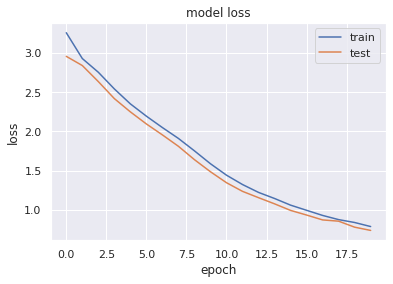

In [ ]:
plt.plot(history20.history['loss'])
plt.plot(history20.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

40 Epoch

In [ ]:
with tf.device('/device:GPU:0'):
    history40 = model.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=20, validation_data=train_dataloader, validation_steps=train_steps, callbacks=[lr,es])

Epoch 1/20
164/164 [==============================] - 276s 2s/step - loss: 0.7374 - val_loss: 0.6919
Epoch 2/20
164/164 [==============================] - 275s 2s/step - loss: 0.7095 - val_loss: 0.6793
Epoch 3/20
164/164 [==============================] - 275s 2s/step - loss: 0.6693 - val_loss: 0.6245
Epoch 4/20
164/164 [==============================] - 274s 2s/step - loss: 0.6301 - val_loss: 0.5915
Epoch 5/20
164/164 [==============================] - 293s 2s/step - loss: 0.6181 - val_loss: 0.6028
Epoch 6/20
164/164 [==============================] - 275s 2s/step - loss: 0.5870 - val_loss: 0.5448
Epoch 7/20
164/164 [==============================] - 275s 2s/step - loss: 0.5614 - val_loss: 0.5208
Epoch 8/20
164/164 [==============================] - 275s 2s/step - loss: 0.5252 - val_loss: 0.4943
Epoch 9/20
164/164 [==============================] - 274s 2s/step - loss: 0.5019 - val_loss: 0.4814
Epoch 10/20
164/164 [==============================] - 275s 2s/step - loss: 0.4890 - val_lo

In [ ]:
model.save_weights(model_path + 'att40/' + 'attention40', save_format='tf') 

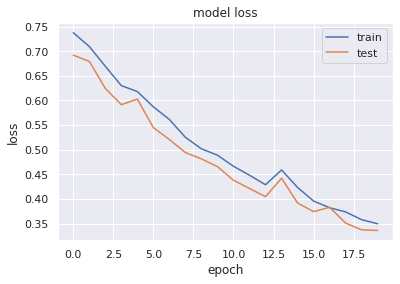

In [ ]:
plt.plot(history40.history['loss'])
plt.plot(history40.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
model.summary()

Model: "Encoder-Decoder-Attention"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_6 (Encoder)          multiple                  11748980  
_________________________________________________________________
decoder_6 (Decoder)          multiple                  17181019  
Total params: 28,929,999
Trainable params: 28,929,999
Non-trainable params: 0
_________________________________________________________________


50 Epoch

In [ ]:
with tf.device('/device:GPU:0'):
    history50 = model.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=10, validation_data=train_dataloader, validation_steps=train_steps, callbacks=[lr,es])

Epoch 1/10
164/164 [==============================] - 275s 2s/step - loss: 0.3443 - val_loss: 0.3212
Epoch 2/10
164/164 [==============================] - 274s 2s/step - loss: 0.3274 - val_loss: 0.3093
Epoch 3/10
164/164 [==============================] - 293s 2s/step - loss: 0.3213 - val_loss: 0.3041
Epoch 4/10
164/164 [==============================] - 276s 2s/step - loss: 0.3100 - val_loss: 0.2939
Epoch 5/10
164/164 [==============================] - 277s 2s/step - loss: 0.2979 - val_loss: 0.2831
Epoch 6/10
164/164 [==============================] - 277s 2s/step - loss: 0.3301 - val_loss: 0.2975
Epoch 7/10
164/164 [==============================] - 277s 2s/step - loss: 0.2996 - val_loss: 0.2764
Epoch 8/10
164/164 [==============================] - 277s 2s/step - loss: 0.2782 - val_loss: 0.2631
Epoch 9/10
164/164 [==============================] - 279s 2s/step - loss: 0.2664 - val_loss: 0.2522
Epoch 10/10
164/164 [==============================] - 278s 2s/step - loss: 0.2576 - val_lo

In [ ]:
model.save_weights(model_path + 'att50/' + 'attention50', save_format='tf') 

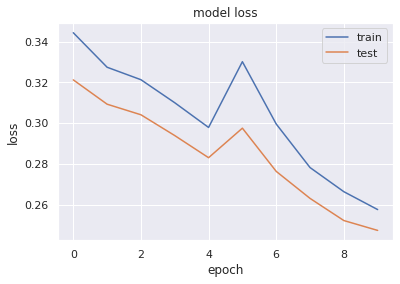

In [ ]:
plt.plot(history50.history['loss'])
plt.plot(history50.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

60 Epoch

In [ ]:
with tf.device('/device:GPU:0'): 
    history60 = model.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=10, validation_data=train_dataloader, validation_steps=train_steps, callbacks=[lr,es])

Epoch 1/10
164/164 [==============================] - 295s 2s/step - loss: 0.3189 - val_loss: 0.3316
Epoch 2/10
164/164 [==============================] - 270s 2s/step - loss: 0.2957 - val_loss: 0.2619
Epoch 3/10
164/164 [==============================] - 269s 2s/step - loss: 0.2603 - val_loss: 0.2427
Epoch 4/10
164/164 [==============================] - 269s 2s/step - loss: 0.2411 - val_loss: 0.2266
Epoch 5/10
164/164 [==============================] - 269s 2s/step - loss: 0.2307 - val_loss: 0.2215
Epoch 6/10
164/164 [==============================] - 269s 2s/step - loss: 0.2261 - val_loss: 0.2660
Epoch 7/10
164/164 [==============================] - 269s 2s/step - loss: 0.2622 - val_loss: 0.2279
Epoch 8/10
164/164 [==============================] - 269s 2s/step - loss: 0.2322 - val_loss: 0.2152
Epoch 9/10
164/164 [==============================] - 269s 2s/step - loss: 0.2134 - val_loss: 0.2029
Epoch 10/10
164/164 [==============================] - 270s 2s/step - loss: 0.2033 - val_lo

In [ ]:
model.save_weights(model_path + 'att60/' + 'attention60', save_format='tf') 

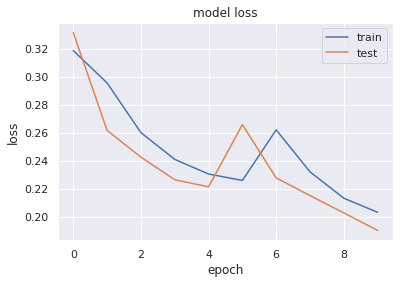

In [ ]:
plt.plot(history60.history['loss'])
plt.plot(history60.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

70 Epoch

In [ ]:
with tf.device('/device:GPU:0'): 
    history70 = model.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=10, validation_data=train_dataloader, validation_steps=train_steps, callbacks=[lr,es])

Epoch 1/10
164/164 [==============================] - 269s 2s/step - loss: 0.1927 - val_loss: 0.1874
Epoch 2/10
164/164 [==============================] - 269s 2s/step - loss: 0.1960 - val_loss: 0.1832
Epoch 3/10
164/164 [==============================] - 270s 2s/step - loss: 0.1959 - val_loss: 0.1887
Epoch 4/10
164/164 [==============================] - 271s 2s/step - loss: 0.1908 - val_loss: 0.1815
Epoch 5/10
164/164 [==============================] - 270s 2s/step - loss: 0.1808 - val_loss: 0.1844
Epoch 6/10
164/164 [==============================] - 269s 2s/step - loss: 0.2471 - val_loss: 0.2087
Epoch 7/10
164/164 [==============================] - 269s 2s/step - loss: 0.1988 - val_loss: 0.1938
Restoring model weights from the end of the best epoch.
Epoch 00007: early stopping


In [ ]:
model.save_weights(model_path + 'att70/' + 'attention70', save_format='tf') 

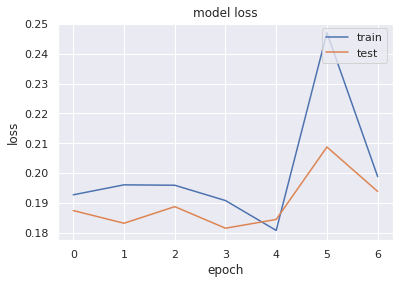

In [ ]:
plt.plot(history70.history['loss'])
plt.plot(history70.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## Model Prediction

In [ ]:
def predict(input_sentence):

  batch_size = 1 
  DECODER_SEQ_LEN = 25
  predict_word_idx = np.zeros((1, 1))
  predict_word_idx[0,0] = 1
  predicted_sentence = ''

  input_sequence=tokenizer_i.texts_to_sequences([input_sentence])
  inputs=pad_sequences(input_sequence,maxlen=25,padding='post')
  inputs=tf.convert_to_tensor(inputs)

  enc_output, state_h, state_c = model.layers[0](inputs)

  for i in range(DECODER_SEQ_LEN):
      dec_output, state_h, state_c, attention_weights, context_vector = model.layers[1].one_step_decoder(predict_word_idx, enc_output, state_h, state_c)
      predict_word_idx = np.reshape(np.argmax(dec_output), (1, 1))
      predicted_sentence += ' ' + tokenizer_o.index_word[int(predict_word_idx)]

      if tokenizer_o.word_index['<end>'] == predict_word_idx:
          return predicted_sentence
      dec_input = tf.expand_dims([predict_word_idx],0)
  return predicted_sentence

#----------------------------------------------------------------------------------------------------
import nltk.translate.bleu_score as bleu

def get_BLEU(model, train, test):
    total_bleu=0
    input_range = 100
    for i in range(0,input_range):
        output_sentence = ' '.join(train['output_text_out'].iloc[i].split()[:-1])
        predicted_sentence = ' '.join(predict(train['input_text'].iloc[i]).split()[:-1])
        output_sentence = [output_sentence.split()]
        predicted_sentence = predicted_sentence.split()
        bleu_score = bleu.sentence_bleu(output_sentence, predicted_sentence)
        total_bleu += bleu_score
    train_avg_bleu = total_bleu/input_range

    total_bleu=0
    input_range = 100
    for i in range(0,input_range):
        output_sentence = ' '.join(test['output_text_out'].iloc[i].split()[:-1])
        predicted_sentence = ' '.join(predict(test['input_text'].iloc[i]).split()[:-1])
        output_sentence = [output_sentence.split()]
        predicted_sentence = predicted_sentence.split()
        bleu_score = bleu.sentence_bleu(output_sentence, predicted_sentence)
        total_bleu += bleu_score
    test_avg_bleu = total_bleu/input_range

    print('Train BLEU Score:', train_avg_bleu)
    print('Test BLEU Score:', test_avg_bleu)

In [ ]:
print('SUMMARY OF AVERAGE BLEU SCORE AT EPOCHS')
print('-'*50)

print('Epoch 20')
model.load_weights(model_path + 'att20/' + 'attention20')
get_BLEU(model, train, test)
print('='*50)

print('Epoch 40')
model.load_weights(model_path + 'att40/' + 'attention40')
get_BLEU(model, train, test)
print('='*50)

print('Epoch 50')
model.load_weights(model_path + 'att50/' + 'attention50')
get_BLEU(model, train, test)
print('='*50)

print('Epoch 60')
model.load_weights(model_path + 'att60/' + 'attention60')
get_BLEU(model, train, test)
print('='*50)

print('Epoch 70')
model.load_weights(model_path + 'att70/' + 'attention70')
get_BLEU(model, train, test)
print('='*50)

SUMMARY OF AVERAGE BLEU SCORE AT EPOCHS
--------------------------------------------------
Epoch 20
Train BLEU Score: 0.5060297339262914
Test BLEU Score: 0.46502215708288264
Epoch 40
Train BLEU Score: 0.7190857397952078
Test BLEU Score: 0.5007111260778252
Epoch 50
Train BLEU Score: 0.7620853332789046
Test BLEU Score: 0.48549955761809627
Epoch 60
Train BLEU Score: 0.7962130445700931
Test BLEU Score: 0.48525404087977786
Epoch 70
Train BLEU Score: 0.8125208729797311
Test BLEU Score: 0.47459013696855934


In [ ]:
model.load_weights(model_path + 'att60/' + 'attention60')

Train

In [ ]:
for i in range(len(train[:5])):
    print("Input Text:", train['input_text'].iloc[i])
    print("Output Text:", ' '.join(train['output_text_out'].iloc[i].split()[:-1]))
    print("Predicted Text:", ' '.join(predict(train['input_text'].iloc[i]).split()[:-1]))
    print('='*120)

Input Text: At the party , the member has variety job .
Output Text: At the party , the members have a variety of jobs .
Predicted Text: At the party , the members have a variety of jobs .
Input Text: Thank you NY .
Output Text: Thank you , NY !
Predicted Text: Thank you , NY !
Input Text: Few last days have been strange .
Output Text: The last few days have been strange .
Predicted Text: A few days last has been strange .
Input Text: I 've started feeling lately that I have n't figured out what kind of relationships I 'm seeking for with people around me .
Output Text: I 've started feeling lately that I have n't figured out what kind of relationships I 'm seeking with the people around me .
Predicted Text: I 've started feeling lately that I have n't figured out what kind of relationships I 'm seeking with the people around me .
Input Text: We also often listen to the CD which includes the conversation amongst native speakers .
Output Text: We also often listened to the CD which incl

Test

In [ ]:
for i in range(len(test[:5])):
    print("Input Text:", test['input_text'].iloc[i])
    print("Output Text:", ' '.join(test['output_text_out'].iloc[i].split()[:-1]))
    print("Predicted Text:", ' '.join(predict(test['input_text'].iloc[i]).split()[:-1]))
    print('='*120)

Input Text: Have you ever over the wall of school ?
Output Text: Have you ever climbed over the wall at school ?
Predicted Text: Have you ever done from the power of school ?
Input Text: It is so narrow that I have to keep my body very fit everytime .
Output Text: It is so narrow that I have to keep my body very fit all the time .
Predicted Text: It is so narrow that I have to keep my body very fast about the seats .
Input Text: You can check the maintenance is finished or not at twitter .
Output Text: You can check whether the maintenance is finished or not on twitter .
Predicted Text: Do you have any weird to finish or not at Twitter .
Input Text: Anyone who gets higher than  scores can pass it .
Output Text: Anyone who gets higher than a , passes it or passes the exam .
Predicted Text: who are taking higher than a regular computer for me .
Input Text: I talked with Rie about our job , but it was a short time .
Output Text: I talked with Rie about our job , but it was just for a shor